In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Debug
# %matplotlib notebook
# pd.options.display.max_rows = 200

In [10]:
df = pd.read_csv("depth-map-data/13-forest/1503619206497711897-cloudpoint.csv", 
                 names = ['x', 'y', 'z', 'intensity', 'ring', 'rotation', 'revolution'])

df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
# np.arctan2 is element-wise arc tangent that chooses the quadrant correctly
df['rotation-angle'] = np.arctan2(df['x'], df['y']) + np.pi
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])

# img_height is number of lasers
# img_width is number of pts/number of lasers
img_height = 80
img_width = 2088

# calculate histogram for inclination angle
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])
df_inclination_arr = df['inclination-angle'].as_matrix()
hist, bin_edges = np.histogram(df_inclination_arr, bins = img_height - 1)

df.sort_values(['rotation-angle'], inplace = True)

bin_size = 64

depth_img = np.zeros((img_width, img_height))

for i in range(img_width):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice['distance'].as_matrix()
    pixel_bin_arr = np.digitize(df_rot_slice['inclination-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_vert_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_vert_loc] = df_rot_slice_arr[j]
    
depth_img = np.rot90(depth_img)

# Interpolation

mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        # skip if not an empty pixel
        if (depth_img[x][y] != 0):
            continue
        
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = depth_img[x_start + x_n][y_start + y_n]
                if (pixel != 0):
                    nn_arr.append(pixel)

        if (len(nn_arr) <= 1):
            if (x < img_height/2):
                mapping[(x, y)] = 100
            continue
        # fill empty pixel with average of filled in neighbors
        nn_avg = sum(nn_arr)/len(nn_arr)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping:
    depth_img[x][y] = mapping[(x, y)]

# Cut off top of image
cut_off = 14
img_height -= cut_off
depth_img = depth_img[cut_off:][:]

In [11]:
# Converts depth matrix to surface normal matrix

# image dimensions in NumPy array, 3rd dimension is for each component of normal vector
normal_img = np.zeros((img_height, img_width, 3))
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        dzdx = (depth_img[x+1][y] - depth_img[x-1][y]) / 2.0
        dzdy = (depth_img[x][y+1] - depth_img[x][y-1]) / 2.0
        direction = (-dzdx, -dzdy, 1.0)
        magnitude = np.sqrt(direction[0]**2 + direction[1]**2 + direction[2]**2)
        normal = direction/magnitude
        normal_img[x][y][0] = normal[0] * .5 + .5
        normal_img[x][y][1] = normal[1] * .5 + .5
        normal_img[x][y][2] = normal[2] * .5 + .5

In [12]:
# # Converts depth matrix to surface normal matrix
# from matplotlib.mlab import PCA

# # image dimensions in NumPy array,
# # 3rd dimension is for each component of normal vector
# normal_img = np.zeros((height, width, 3))
# # number of nearest point neighbors
# # i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
# nn_radius = 2

# for x in range(nn_radius, depth_img.shape[0] - nn_radius):
#     for y in range(nn_radius, depth_img.shape[1] - nn_radius):
#         nn_matrix = np.zeros((2 * nn_radius + 1, 2 * nn_radius + 1))
#         x_start = x - nn_radius
#         y_start = y - nn_radius
#         for x_n in range(2 * nn_radius + 1):
#             for y_n in range(2 * nn_radius + 1):
#                 nn_matrix[x_n][y_n] = depth_img[x_start + x_n][y_start + y_n]
              
#         # perform PCA
#         pca_result = PCA(nn_matrix)
        
#         eigvals = pca_result.s
#         eigvecs = pca_result.Wt
#         # sort eigenvalue in decreasing order
#         idx = np.argsort(eigvals)[::-1]
#         # eigvals = eigvals[idx]
#         # sort eigenvectors according to same index
#         eigvecs = eigvecs[:,idx]
        
#         # the eigenvector corresponding to the 3rd smallest eigenvalue
#         # represents the surface normal of the regression plane
#         normal = eigvecs[2]
        
#         normal_img[x][y][0] = normal[0] * .5 + .5
#         normal_img[x][y][1] = normal[1] * .5 + .5
#         normal_img[x][y][2] = normal[2] * .25 + .75

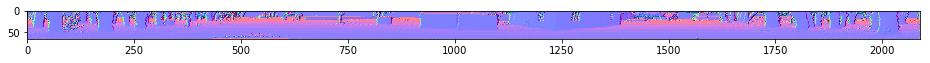

In [13]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(normal_img)

fig.savefig('surface-normal.png', dpi = 300)